In [1]:
from thermalmodels_cut import FirstOrderModel
from DR_thermalenvironments_cut import DirectControlEnv, SetpointDeltaEnv, DirectSetpointEnv

from stable_baselines.deepq.policies import MlpPolicy
from stable_baselines import DQN, A2C,PPO2,ACER

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [2]:
from itertools import cycle
import pandas as pd
import numpy as np

In [3]:
df = pd.read_csv('combined_csv.csv')

In [4]:
prices = df[["Spot Price ($/MWh)"]]      
prices = np.array(prices)


In [5]:
np.min(prices)

-41.38

In [6]:
from stable_baselines.common.policies import FeedForwardPolicy, register_policy
from stable_baselines.common.vec_env import DummyVecEnv
from stable_baselines import A2C

# Custom MLP policy of three layers of size 128 each
class CustomPolicy(FeedForwardPolicy):
    def __init__(self, *args, **kwargs):
        super(CustomPolicy, self).__init__(*args, **kwargs,
                                           net_arch=[dict(pi=[128, 128, 128],
                                                          vf=[256,128,128,128])],
                                           feature_extraction="mlp")

# Register the policy, it will check that the name is not already taken
register_policy('CustomPolicy', CustomPolicy)

In [7]:
from stable_baselines.deepq.policies import FeedForwardPolicy

In [8]:
class CustomDQNPolicy(FeedForwardPolicy):
    def __init__(self, *args, **kwargs):
        super(CustomDQNPolicy, self).__init__(*args, **kwargs,
                                           layers=[32,32,32,32],
                                           layer_norm=True,
                                           feature_extraction="mlp")

In [9]:
#Instantiate the firstorder model
tcl = FirstOrderModel(10*60, 20*60, 21,2,0.2)  # Calling the function firstorder model arg1,2- seconds to heat and seconds to cool, arg3-Goal, flex and noise

env = DirectSetpointEnv(tcl,prices)

model3 = DQN(CustomDQNPolicy, env, verbose=1, exploration_fraction=0.20, exploration_final_eps=0.1,prioritized_replay = True,buffer_size=10000,double_q = True,
             seed = 30111, tensorboard_log="/floyd/home/hot_dqn")    # 
#model2 = ACER("MlpPolicy", env, gamma=0.90,verbose=0,seed = 122,tensorboard_log="/floyd/home/fixhot",lr_schedule="double_linear_con",learning_rate=0.0004)
#model = PPO2("MlpPolicy", env, gamma=0.96, verbose=0,tensorboard_log="/floyd/home/fix",seed = 121);
model3.learn(total_timesteps=120000)
model3.save("fixed_cut1")








Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Please use `layer.__call__` method instead.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where












--------------------------------------
| % time spent exploring  | 9        |
| episodes                | 100      |
| mean 100 episode reward | 161      |
| steps                   | 28512    |
--------------------------------------
--------------------------------------
| % time spent exploring  | 9        |
| episodes                | 200      |
| mean 100 episode reward | 166      |
| steps                   | 57312    |
--------------------------------------
--------------------------------------
| % time spent exploring  | 9        |
| episodes                | 300      |
| mean 100 episode reward | 168      |
| steps                   | 86112    |
--------------------------------------
--------------------------------------
| % time spen

In [28]:
model3.save("fixed_Sched1")

In [20]:
from stable_baselines.common.vec_env import VecVideoRecorder, DummyVecEnv

In [36]:
from thermalmodels import FirstOrderModel
from DR_thermalenvironments_price import DirectControlEnv, SetpointDeltaEnv, DirectSetpointEnv

from stable_baselines.deepq.policies import MlpPolicy
from stable_baselines import DQN, A2C,PPO2,ACER

In [37]:
tcl = FirstOrderModel(25*60, 35*60, 21,2,0.2)  # Calling the function firstorder model arg1,2- seconds to heat and seconds to cool, arg3-Goal, flex and noise

env = DirectSetpointEnv(tcl,prices,policy1,policy2)

In [38]:
env = DummyVecEnv([lambda: env])

In [27]:
def evaluate(model,env,n_eval_episodes,return_episode_rewards = False,deterministic = True, baseline = False):
    episode_rewards, episode_lengths = [], []
    episode_costs,episode_comforts = [],[]
    for _ in range(n_eval_episodes):
       # if _ == 0:
        obs = env.reset()
        done, state = False, None
        episode_reward = 0.0
        episode_length = 0
        episode_cost = 0.0
        episode_comfort = 0.0
        
        while not done:
            action, state = model.predict(obs, state=state, deterministic=deterministic)
            if baseline:
                obs, reward, done, _info = env.step(21) # Ignore what the policy is predicting always set to 21
                               
            else:
                obs, reward, done, _info = env.step(action)
            episode_reward += reward
            episode_length += 1
            episode_cost += _info['Cost'] #Add up costs 
            episode_comfort += _info['Comfort']
        
        episode_rewards.append(episode_reward)
        episode_lengths.append(episode_length)
        episode_costs.append(episode_cost)
        episode_comforts.append(episode_comfort)
        
    mean_reward = np.mean(episode_rewards)
    std_reward = np.std(episode_rewards)
    mean_cost = np.mean(episode_costs)
    std_cost = np.std(episode_costs)
    mean_comfort = np.mean(episode_comforts)
    std_comfort = np.std(episode_comforts)
    
    if return_episode_rewards:
        return episode_rewards, episode_lengths
    return mean_reward, std_reward,mean_cost,std_cost,mean_comfort,std_comfort

In [32]:
# Model A2C Policy
tcl = FirstOrderModel(10*60,20*60, 21,2,0.2) 
env = DirectSetpointEnv(tcl,prices)
mean_reward, std_reward,sum_cost,std_cost,sum_comfort,std_comfort = evaluate(model3, env, n_eval_episodes=30,baseline = True)
print(f"mean_reward:{mean_reward:.2f} +/- {std_reward:.2f}")
print(f"total_costs:{sum_cost:.2f} +/- {std_cost:.2f}")
print(f"total_comfort:{sum_comfort:.2f} +/- {std_comfort:.2f}")

mean_reward:229.13 +/- 2.16
total_costs:5.92 +/- 1.44
total_comfort:288.00 +/- 0.00


In [33]:
# Model A2C Policy
tcl = FirstOrderModel(10*60,20*60, 21,2,0.2) 
env = DirectSetpointEnv(tcl,prices)
amean_reward, astd_reward,asum_cost,astd_cost,asum_comfort,astd_comfort = evaluate(model3, env, n_eval_episodes=30)
print(f"mean_reward:{amean_reward:.2f} +/- {astd_reward:.2f}")
print(f"total_costs:{asum_cost:.2f} +/- {astd_cost:.2f}")
print(f"total_comfort:{asum_comfort:.2f} +/- {astd_comfort:.2f}")

mean_reward:221.30 +/- 3.82
total_costs:6.26 +/- 1.57
total_comfort:280.28 +/- 4.15


In [15]:
model_new = A2C.load("trans01",tensorboard_log="/floyd/home/trans_t1",seed=100011)

Loading a model without an environment, this model cannot be trained until it has a valid environment.


In [18]:
env = DummyVecEnv([lambda: env])
model_new.set_env(env)

In [ ]:
# Model A2C Policy
tcl = FirstOrderModel(22*60,33*60, 21,2,0.2) 
env = DirectSetpointEnv(tcl,prices,policy1,policy2)
amean_reward, astd_reward,asum_cost,astd_cost,asum_comfort,astd_comfort = evaluate(model_new, env, n_eval_episodes=50)
print(f"mean_reward:{amean_reward:.2f} +/- {astd_reward:.2f}")
print(f"total_costs:{asum_cost:.2f} +/- {astd_cost:.2f}")
print(f"total_comfort:{asum_comfort:.2f} +/- {astd_comfort:.2f}")

In [13]:
for i in price3:
    if i > 80:
        print(i)

In [11]:
obs = env.reset()

In [50]:
obs = [18.85872821, 18         ,38.50959   ]

In [26]:
seconds3 = []
price3 = []
reward3 = []
temp3 = []
setpoint3 = []
times = []
obs = env.reset()
dones = False
#while not dones:
for i in range(550):
    action, _states = model3.predict(obs)
   
    obs, rewards, dones, info = env.step(action)
    
    seconds3.append(info['SecondsON'])
    setpoint3.append((info['Action']/2) + 10)
    reward3.append(rewards)
    times.append(i)
    temp3.append(obs[0])
    price3.append(info['Price'])
    print(obs[0],rewards,info)
   # env.render(mode='human')

20.42189455765436 1.0 {'SecondsON': 0, 'Price': 39.5, 'Action': 16, 'Cost': 0.0, 'Comfort': 1.0}
19.749853385613793 1.0 {'SecondsON': 0, 'Price': 39.5, 'Action': 16, 'Cost': 0.0, 'Comfort': 1.0}
19.10915692948983 0.9999491058891803 {'SecondsON': 0, 'Price': 42.63864, 'Action': 16, 'Cost': 0.0, 'Comfort': 0.9999491058891803}
18.49834323835331 0.9967546830552778 {'SecondsON': 0, 'Price': 42.4941, 'Action': 16, 'Cost': 0.0, 'Comfort': 0.9967546830552778}
17.91601854822325 0.9861316899351552 {'SecondsON': 0, 'Price': 33.69294, 'Action': 16, 'Cost': 0.0, 'Comfort': 0.9861316899351552}
18.046000145773785 0.9268594240356437 {'SecondsON': 13, 'Price': 44.95227, 'Action': 16, 'Cost': 0.04058191041666666, 'Comfort': 0.9877322896606436}
19.500732131410516 0.8492623844295757 {'SecondsON': 30, 'Price': 48.06962, 'Action': 23, 'Cost': 0.10014504166666667, 'Comfort': 0.9994799469295758}
20.375856780817102 1.0 {'SecondsON': 0, 'Price': 47.86035, 'Action': 16, 'Cost': 0.0, 'Comfort': 1.0}
19.7558930210

In [27]:
%matplotlib inline
import matplotlib.pyplot as plt

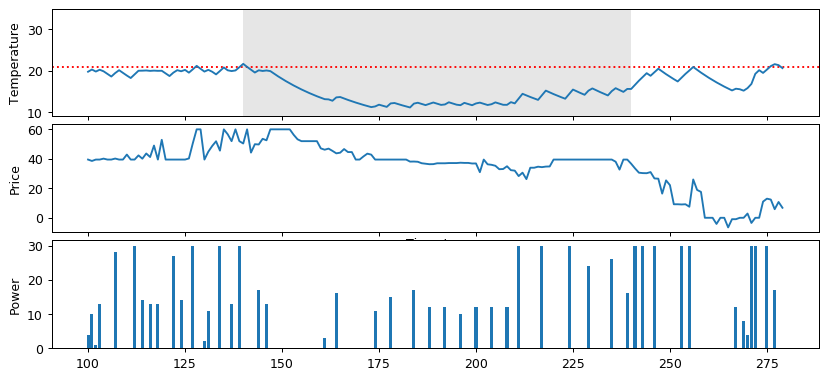

In [29]:
### Plot the resulting temperature trajectory.
f, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(11,5), dpi=90)
plt.subplots_adjust(hspace=0.075) # Reduce space between plots
ax1.axvspan(140, 240, facecolor='0.90') # Shade the demand-response times with grey background
#ax1.axvspan(220, 250, facecolor='0.85')

#ax2.axvspan(60, 66, facecolor='0.85') # Shade the  demand-response times with grey background
#ax2.axvspan(200, 206, facecolor='0.85')

ax1.axhline(y=21, linestyle=':', color='red') # Plot the goal temperature
ax1.plot(times[100:280], temp3[100:280]) # Plot the observed temperatures
ax1.set_ylabel('Temperature')
ax1.set_ylim(9,35)
ax2.plot(times[100:280], price3[100:280]) # Plot the activations on a separate axis.
ax2.set_xlabel('Timestep')
ax2.set_ylabel('Price');
ax3.bar(times[100:280],seconds3[100:280])
ax3.set_ylabel('Power');

In [30]:
min(reward3)

-0.1234375

In [32]:
min(reward3)

-2641.95817845267

In [ ]:
### Plot the resulting temperature trajectory.
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(11,5), dpi=90)
plt.subplots_adjust(hspace=0.075) # Reduce space between plots
#ax1.axvspan(start, start+length, facecolor='0.95') # Shade the demand-response times with grey background
ax1.axhline(y=20, linestyle=':', color='black') # Plot the goal temperature
ax1.plot(times, temps) # Plot the observed temperatures
ax1.set_ylabel('Temperature')
ax1.set_ylim(17.5,22.5)
ax2.bar(times, uses) # Plot the activations on a separate axis.
ax2.set_xlabel('Timestep')
ax2.set_ylabel('Power');